# The cost of running a bitcoin node
An evidence-based projection

## Motivation
There is a widespread notion in the Bitcoin community that, were blocks allowed
to grow at their natural unconstrained rate, soon the costs of running a fully
validating network node (storing and validating a full copy of the blockchain)
would be out of reach of all but the largest corporations using clusters of
computers so large they could only fit in datacenters. Prominent (and presumably
qualified) technical members of the community have made repeated statements to
this effect. This (among other things, not least of which has been openly censoring
dissenting viewpoints on prominent discussion forums) has done much to sway the
opinions of non-technical members of the community.

The following notebook aims to calculate from available numbers the actual expected
cost of running such a node. It is my sincere hope that, going forward, discussions 
surrounding this topic be based on facts and evidence. Indeed, it is too important
a topic not to employ our analytical capabilities to their fullest.

Cryptocurrency has the potential to improve the lives of millions, if not billions,
of people on this planet if it is allowed to.

While it is by no means necessary for the majority of users to run a fully validating
node, it is important for the health of the network that a broad spectrum of them
be able to do so and choose to do so. Were an attacker (or an aligned coalition of
them) to gain control over **all** full copies of the blockchain **and** over 50% of
the network's hashing power, they would have little problem passing off counterfeit
bitcoin to the rest of the network unnoticed (and thus unpunished by a drop in market
price). Dissuading such an attack requires keeping at least one fully copy of the
blockchain out of the hands of would-be attackers. Strongly dissuading such an attack
means having enough copies in the hands of enough unaligned parties that the expense
involved in "taking out" **all** of them is beyond any potential profit to be gained.

## Scope
I'll be examining two claims about unconstrained block growth, namely that 
it will lead to:
- nodes "only in datacenters", and
- node costs so high only large corporations could afford to run them

I will estimate costs for a fully validating network participant near the edge.
This includes:
- block explorers
- small businesses
- blockchain data service outfits (large and small)
- payment processors (large and small)
- exchanges
- technically inclined enthusiasts
- etc.

I will not be estimating costs for:
- mining farm operators (who may spend more for faster validation)
- those uploading many copies of every block they receive (as more centrally
connected nodes might).

## Calculations
### Block Size
First we must get an idea of what "unconstrained block size growth" means
quantitatively. To study this we must look at the growth in bitcoin's block
size in the years before that growth was constrained by the old 1MB spam limit.

The following code pulls data from [blockchain.info](https://blockchain.info)'s
API and performs an exponential regression to find the unconstrained growth rate.

In [1]:
import requests

# grab historical block size data from blockchain.info
r = requests.get('https://api.blockchain.info/charts/avg-block-size?timespan=all&format=csv')

#r = requests.get('https://api.blockchain.info/charts/blocks-size?timespan=all&format=csv')
#blockchain_size = pd.read_csv(io.StringIO(r.text), header=None,
#                    names=('timestamp', 'size_mb'))

[Text(0,0.5,'Block Size (MB)'), Text(0.5,0,'Date')]

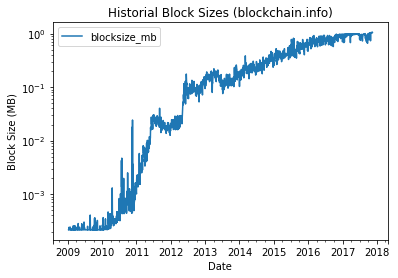

In [248]:
import io

import scipy.optimize
import pandas as pd
import numpy as np

sizes = pd.read_csv(io.StringIO(r.text), header=None,
                    names=('timestamp', 'blocksize_mb'))

# convert timestamp to native timestamps
sizes['timestamp'] = sizes['timestamp'].astype('datetime64[ns]')

# graph sizes for sanity check
%matplotlib inline
ax = sizes.plot(x='timestamp', y='blocksize_mb', logy=True,
                title="Historial Block Sizes (blockchain.info)")
ax.set(ylabel="Block Size (MB)", xlabel="Date")

[Text(0,0.5,'Block Size (MB)'), Text(0.5,0,'Year')]

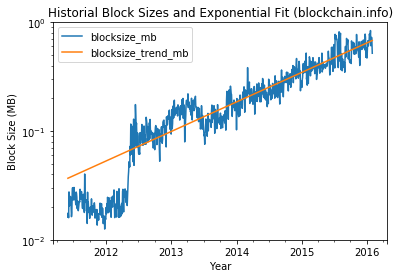

In [378]:
def add_years_column(df):
    """Add a column to the given dataframe for 'years-since-inception'"""
    def to_years(ts):
        return (ts - df.loc[0, 'timestamp']).days / 365
    df['years'] = df['timestamp'].apply(to_years)
    return df

sizes = add_years_column(sizes)

# take a subset from before blocks got full
subset = sizes.query('"2011-06-01" < timestamp < "2016-02-01"').copy()

# fit an exponential trendline to estimate annual growth
def exp_growth(t, a, c):
    return a*np.exp(t/c)

x_data = subset['years']
y_data = subset['blocksize_mb']
popt, pcov = scipy.optimize.curve_fit(exp_growth, x_data, y_data)

def add_blocksize_trend(df):
    """Add a column to the given `df` projecting block size from our
    computed exponential growth model"""
    df['blocksize_trend_mb'] = exp_growth(df['years'], *popt)
    return df

subset = add_blocksize_trend(subset)

# graph that subset
ax = subset.plot(x='timestamp', y='blocksize_mb', logy=True, ylim=(1e-2, 1e0),
                title="Historial Block Sizes and Exponential Fit (blockchain.info)")
subset.plot(ax=ax, x='timestamp', y='blocksize_trend_mb')
ax.set(ylabel="Block Size (MB)", xlabel="Year")

The data from before TX volume started to become constrained fits a
remarkably straight line when plotted on a log scale, a classic exponential
growth model. It would be fair to assume, were block sizes to be allowed
to grow unconstrained, that they would become more full at the rate
shown here. I'm not sure there's a case for arguing blocks would grow much faster
than this, as they did not in this period.

Next we calculate exactly what that yearly growth rate is:

In [250]:
# calculate yearly growth (in percent) from our trendline
years = exp_growth([1,2], *popt)
growth = (years[1]/years[0] - 1.0) * 100
print("Yearly growth: {:.1f}%".format(growth))

Yearly growth: 86.8%


Which is a very respectable pace. Indeed it is faster than Moore's Law, which
when first observed was a yearly growth rate of only 42%, and has since slowed.

Given this greater-than-Moore growth rate, it is understandable how one familiar
with exponentials and armed with no other information might soon conclude that
Bitcoin's growth is unsustainable.

This ignores the space that Bitcoin plays in however: payments.

### Bitcoin's competition

There is, I would argue, a point somewhere between Visa-scale and the scale
of "all digital payments on Earth" where Bitcoin's growth rate slows to a more
manageable pace. "All digital payments on Earth", for example, only grew 10%
[in 2015](https://globenewswire.com/news-release/2016/09/22/873708/0/en/Global-Digital-Payment-Transactions-Set-to-Reach-10-Percent-Growth-for-First-Time-Finds-World-Payments-Report-2016.html),
and its unlikely that anybody is going to be storing their DVD collection on
the blockchain no matter how low fees get (at 1 cent per TX, storing a gigabyte
on-chain would cost north of $16,000).

That being said, let's take a look at Bitcoin's competitors in the payments space,
and what it would take (in terms of block size) for Bitcoin to outcompete them.
The sources for the numbers below can be found in the comments, but are also
[here](http://www.businesswire.com/news/home/20170126006022/en/PayPal-Reports-Fourth-Quarter-Full-Year-2016),
[here](https://www.swift.com/about-us/swift-fin-traffic-figures),
[here](https://newsroom.mastercard.com/press-releases/mastercard-incorporated-reports-fourth-quarter-and-full-year-2016-financial-results/),
[here](http://marketrealist.com/2016/12/visa-and-mastercard-see-a-strong-rise-in-transactions-volumes/), and
[here](https://globenewswire.com/news-release/2016/09/22/873708/0/en/Global-Digital-Payment-Transactions-Set-to-Reach-10-Percent-Growth-for-First-Time-Finds-World-Payments-Report-2016.html).

In [251]:
df = pd.DataFrame(data={
    'competitor': ['PayPal', 'SWIFT', 'MasterCard', 'VISA', 'Global'],
    'yearly_tx': [1.8e9*4, 29e6*365, 15.2e9*4, 41.8e9*4, 426.3e9]
})

# Sources:
# PayPal did 1.8 billion TX in Q4 2016
# http://www.businesswire.com/news/home/20170126006022/en/PayPal-Reports-Fourth-Quarter-Full-Year-2016
# SWIFT peaks at ~29 million transfers per day
# https://www.swift.com/about-us/swift-fin-traffic-figures
# Mastercard did 15.2 billion TX in Q4 2016
# https://newsroom.mastercard.com/press-releases/mastercard-incorporated-reports-fourth-quarter-and-full-year-2016-financial-results/
# VISA did 41.8 billion transactions in Q3 2016
# http://marketrealist.com/2016/12/visa-and-mastercard-see-a-strong-rise-in-transactions-volumes/
# Global digital payments were 426.3 billion TX in 2015 (with 10% annual growth)
# https://globenewswire.com/news-release/2016/09/22/873708/0/en/Global-Digital-Payment-Transactions-Set-to-Reach-10-Percent-Growth-for-First-Time-Finds-World-Payments-Report-2016.html

# some constants we'll use
# https://tradeblock.com/blog/analysis-of-bitcoin-transaction-size-trends
transaction_size_mb = 600.0 / (1024**2)
years_per_second = 1.0 / (365*24*60*60)
seconds_per_block = 10*60

df['avg_tps'] = df['yearly_tx'] * years_per_second
df['blocksize_mb'] = df['avg_tps'] * seconds_per_block * transaction_size_mb
df = df.set_index('competitor')
competitors = df
competitors

,yearly_tx,avg_tps,blocksize_mb
competitor,,,
PayPal,7.200000e+09,228.310502,78.384190
SWIFT,1.058500e+10,335.648148,115.235647
MasterCard,6.080000e+10,1927.955353,661.910941
VISA,1.672000e+11,5301.877220,1820.255088
Global,4.263000e+11,13517.884323,4640.997273


In the table above we can see that Bitcoin begins to eclipse VISA's average
throughput of 5,300 transactions per second (TPS) with 1.8GB blocks, and that
it achieves approximate world domination (more TPS than all other digital payments
combined globally) with 4.6GB blocks (13,517 TPS).

It should be noted that at 3 cents per TX, miner revenue with 4.6GB blocks is
roughly $230,000 per block, more than twice today's block reward.

### Growing to dominate the world

Next we project Bitcoin's unconstrained growth rate (calculated earlier)
into the future to see what we find there.

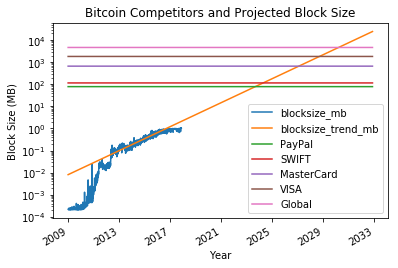

In [383]:
# project out 15 years
years_out = 15
df = sizes.copy()
new_time = pd.DataFrame()
new_time['timestamp'] = pd.date_range(df['timestamp'].max(),
                                      periods=years_out*365/2, freq='2D')
df = add_years_column(df.append(new_time, ignore_index=True))
df = add_blocksize_trend(df)

ax = df.plot(x='timestamp', y='blocksize_mb', logy=True,
             title="Bitcoin Competitors and Projected Block Size")
df.plot(ax=ax, x='timestamp', y='blocksize_trend_mb')

# plot the competitors on the graph as well
for competitor in competitors.index:
    df[competitor] = competitors.loc[competitor, 'blocksize_mb']
    df.plot(ax=ax, x='timestamp', y=competitor)

ax.set(ylabel="Block Size (MB)", xlabel="Year")
future_sizes = df

## Projecting node costs

Now that we know what rate Bitcoin's blocks are likely to grow at (if
unconstrained), we can begin to calculate the costs of running a node
to handle such large amounts of data.

### Cost of acquiring storage

The best numbers I know for the true cost of acquiring storage come from
[Backblaze](https://www.backblaze.com/blog/hard-drive-cost-per-gigabyte/).
If you haven't read their blog yet, I can highly recommend it. I put their
cost graph through a [digitizing tool](https://apps.automeris.io/wpd/) to
get the following numbers, and fit a logarithmic decay curve to the data.

array([ 0.01809169,  0.08042303,  2.54019397])

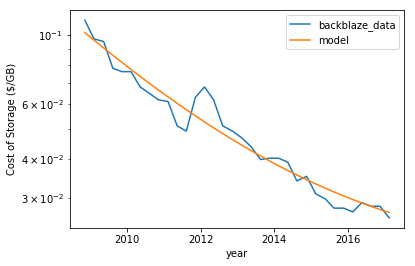

In [385]:
# Costs
# HDD cost trends
# https://www.backblaze.com/blog/hard-drive-cost-per-gigabyte/
# digitized by https://apps.automeris.io/wpd/

df = pd.read_csv(io.StringIO(
"""2008.8587196467993, 0.11147286821705424
2009.1059602649007, 0.09713178294573639
2009.3708609271523, 0.09519379844961236
2009.618101545254, 0.07813953488372088
2009.8653421633555, 0.07620155038759686
2010.1125827814571, 0.07620155038759686
2010.3598233995585, 0.06806201550387593
2010.6070640176602, 0.06496124031007748
2010.8543046357618, 0.06186046511627903
2011.1192052980134, 0.06108527131782944
2011.3664459161148, 0.05100775193798446
2011.6136865342164, 0.04906976744186044
2011.860927152318, 0.06302325581395346
2012.1081677704196, 0.06806201550387593
2012.355408388521, 0.06186046511627903
2012.6026490066226, 0.05100775193798446
2012.8675496688743, 0.04906976744186044
2013.114790286976, 0.04674418604651161
2013.3796909492276, 0.043643410852713144
2013.626931567329, 0.039767441860465075
2013.8741721854306, 0.0401550387596899
2014.1214128035322, 0.0401550387596899
2014.3686534216336, 0.03899224806201548
2014.6158940397352, 0.033953488372093
2014.8807947019868, 0.035116279069767414
2015.1280353200884, 0.03085271317829455
2015.39293598234, 0.029689922480620135
2015.6225165562914, 0.0277519379844961
2015.887417218543, 0.0277519379844961
2016.1346578366447, 0.02697674418604648
2016.3818984547463, 0.028914728682170515
2016.6291390728477, 0.028139534883720896
2016.8763796909493, 0.028139534883720896
2017.123620309051, 0.025813953488372066
"""), names=('year', 'backblaze_data'))

# get the axis to fit our blocksize model start date of Jan, 2009
df['since_09'] = df['year'] - 2009

def exp_decay(t, a, b, c):
    return a + b*np.exp2(-t/c)

x_data = df['since_09']
y_data = df['backblaze_data']
popt_storage_cost, pcov = scipy.optimize.curve_fit(exp_decay, x_data, y_data, )

df['model'] = exp_decay(x_data, *popt_storage_cost)

ax = df.plot(x='year', y='backblaze_data')
df.plot(ax=ax, x='year', y='model', logy=True)
ax.set(ylabel="Cost of Storage ($/GB)")

# add storage cost column to our overall model
df = future_sizes
df['storage_cost_per_gb'] = exp_decay(df.loc[:, 'years'], *popt_storage_cost)

popt_storage_cost

The model predicts continuously falling prices for platter hard drives
down to a floor of 1.81 cents/GB, consistent with recent observations
that hard drive prices aren't falling as fast as they used to.

To predict node costs we will not be assuming any unforseen breakthroughs
in the cost of storage, just the gentle drop to the physical limits of
platter hard drives Backblaze has been observing since 2008.

### Total size of the blockchain

Integrating block sizes over time gets us a projected size for the entire
blockchain.

[Text(0,0.5,'Chain Size (GB)'), Text(0.5,0,'Year')]

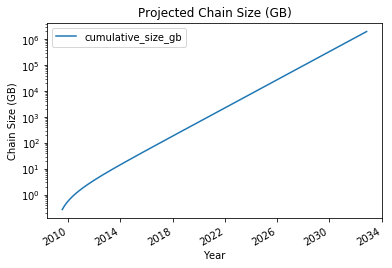

In [387]:
pd.options.display.float_format = '{:.6f}'.format

blocks_per_hour = 6

df = future_sizes
y = df['blocksize_trend_mb']
x = df['timestamp']
mean_y = (y[:-1] + y.shift(-1)[:-1]) / 2
delta_t = (x.shift(-1)[:-1] - x[:-1])

# the number of blocks solved during each time step in our projection
delta_blocks = delta_t * blocks_per_hour/pd.Timedelta("1 hour")

year8 = int(8*365/2)

# calculate additional chain size per time step, scale to GB
scaled_delta_gb = mean_y.multiply(delta_blocks) / 1024

# integrate chain size steps to get total chain size at each time step
df['cumulative_size_gb'] = scaled_delta_gb.cumsum(axis='index').shift(2).fillna(0)

# plot for a sanity check
ax = df.loc[100:].plot(x='timestamp', y='cumulative_size_gb', logy=True,
             title="Projected Chain Size (GB)")
ax.set(ylabel="Chain Size (GB)", xlabel="Year")

From this we can see that the entire chain will occupy roughly 1 terabyte
in 2020, and 1 petabyte in 2030.

To get a sense of how much this will cost per month to maintain, I'll multiply
the projected cost of storage by the projected growth per month at all points
in our model.

In [400]:
# calculate chain growth rate in GB/month
df = future_sizes
finite_growth_gb = df['cumulative_size_gb'].diff()
periods_per_month = df['timestamp'].diff().divide(pd.Timedelta("30 days")).pow(-1)
monthly_growth_gb = finite_growth_gb.multiply(periods_per_month)

# calculate the monthly cost of new storage for the array
df['monthly_new_storage_cost'] = monthly_growth_gb.multiply(df['storage_cost_per_gb'])

# calculate the cost of buying storage for the whole chain at any time
df['startup_storage_cost'] = df['cumulative_size_gb'].multiply(df['storage_cost_per_gb'])

# up to 20% of the storage array will need to be replaced every
# year in addition to adding new storage. Mechanical drives wear out.
df['monthly_storage_replace_cost'] = df['cumulative_size_gb'] * 0.2 * df['storage_cost_per_gb'] / 12

# pick out 4 years and make a table of the expected costs
table = []
for year in [2017, 2020, 2025, 2030]:
    ts = pd.Timestamp(str(year))
    table.append(df.loc[(df['timestamp'] - ts).abs().argsort()][:1])
df2 = pd.concat(table)
df2.loc[:, ('timestamp', 'blocksize_trend_mb', 'monthly_new_storage_cost', 'monthly_storage_replace_cost')]

,timestamp,blocksize_trend_mb,monthly_new_storage_cost,monthly_storage_replace_cost
1460,2017-01-01,1.210812,0.138005,0.044554
2009,2020-01-02,7.907040,0.732980,0.238004
2922,2025-01-01,180.196831,14.454443,4.698109
3835,2030-01-01,4106.580767,316.316276,102.816343


From this projection, we can see that a node operator sometime in 2030 (handling
4.1GB blocks) can expect to pay $419 per month for new hard drives (assuming they wish
to store the entire chain). That includes $316 worth of hard drives for new
chain data, and $103 to replace broken drives in their array.

Far from being an expense only big businesses can afford, $419 per month is
less than half the cost of a single minimum wage employee (not counting benefits
and payroll taxes).

Node operators in 2025 can expect to pay less than $20 per month for new
drives.

### Space to hold all those drives

Numbers on drive density were harder for me to come by. Drive densities have
been growing exponentially for the last 30 years, but are slowing down as we
reach physical limits. I chose a linear trend to model drive densities going
forward, and based it on when Backblaze started introducing various size drives
into their arrays. This may be too pessimistic or optimistic a model, but I
suspect its balanced. It predicts 19TB drives being available in 2025, and
25TB drives being available in 2030, which I think is quite conservative.

[Text(0,0.5,'3.5-inch Drive Capacity (TB)'),
 Text(0.5,0,'Year Introduced'),
 Text(0.5,1,'Hard Drive Density Trend (TB per 3.5-inch drive)')]

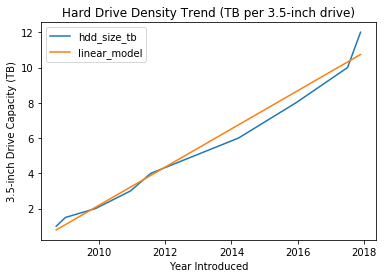

In [406]:
# calculate the space taken up by all the drives
# projection of future drive density taken from Backblaze data
df = pd.read_csv(io.StringIO(
"""2008.719759,1
2008.999498,1.5
2009.899543,2
2010.956582,3
2011.57071,4
2014.21084,6
2015.944662,8
2017.5,10
2017.89,12
"""), names=('year_introduced', 'hdd_size_tb'))

# get the axis to fit our blocksize model start date of Jan, 2009
df['since_09'] = df['year_introduced'] - 2009

def linear(t, a, b):
    return a + b*t

x_data = df['since_09']
y_data = df['hdd_size_tb']
popt_drive_size, pcov = scipy.optimize.curve_fit(linear, x_data, y_data)

df['linear_model'] = linear(x_data, *popt_drive_size)

ax = df.plot(x='year_introduced', y='hdd_size_tb')
df.plot(ax=ax, x='year_introduced', y='linear_model')
ax.set(ylabel="3.5-inch Drive Capacity (TB)",
      title="Hard Drive Density Trend (TB per 3.5-inch drive)",
      xlabel="Year Introduced")

In [415]:
# calculate the number of racks required to store the chain
df = future_sizes
# linear model predicts sizes in TB, we want GB (multiply by 1024)
df['hdd_density_gb_per_drive'] = linear(df.loc[:, 'years'], *popt_drive_size) * 1024
df['min_drives'] = df['cumulative_size_gb'].divide(df['hdd_density_gb_per_drive'])

# 60 drives can fit in a 4U enclosure
# https://www.backuppods.com/collections/backblaze-storage-pod-6-0
df['total_rack_space_u'] = df['min_drives'].multiply(4/60)

# pick out 4 years and make a table of the expected densities
table = []
for year in [2017, 2020, 2025, 2030]:
    ts = pd.Timestamp(str(year))
    table.append(df.loc[(df['timestamp'] - ts).abs().argsort()][:1])
df2 = pd.concat(table)
df2.loc[:, ('timestamp', 'cumulative_size_gb', 'hdd_density_gb_per_drive',
            'min_drives', 'total_rack_space_u')]

,timestamp,cumulative_size_gb,hdd_density_gb_per_drive,min_drives,total_rack_space_u
1460,2017-01-01,98.440732,10008.138500,0.009836,0.000656
2009,2020-01-02,646.562105,13342.862991,0.048458,0.003231
2922,2025-01-01,14749.384350,18898.708723,0.780444,0.052030
3835,2030-01-01,336144.485191,24454.554454,13.745680,0.916379


It is with this last set of numbers that we start to get a sense of exactly how
much data we can store these days (and will be able to store).

Around 2030, this model predicts the blockchain weighs 336TB.
With 2030's expected 24TB drives however, we would only need 14 of them to
store the entire thing. That's just under 1/4
of the number of slots available in modern high density
[storage pods](https://www.backuppods.com/collections/backblaze-storage-pod-6-0),
which themselves take up only 4U of a typically 52U rack.

Far from needing an entire datacenter, the storage portion of a
**world-domination-scale** Bitcoin node would fit in any server closet or garage,
and maybe even under your desk.

### Bandwidth

To figure bandwidth requirements for our hypothetical "edge" network participant,
it helps to realize that someone just following the chain (i.e. not mining blocks)
can afford to run several minutes behind the mining network. Non-mining nodes
do not participate in block relay between miners (unless the Fibre network is
down for some reason), so needn't have orders of magnitude more bandwidth than
is required to send an average block in 10 minutes like miners might.

A user on the edge should still strive to be a good network neighbor and not a net consumer
of network bandwidth. The most efficient the network could be configured to run
is like a BitTorrent swarm, where the total swarm "upload ratio" must average 1.0, no
more, no less. Those with more bandwidth available should certainly help carry
the load from SPV clients (what might be called "leechers" in the BitTorrent world),
but someone trying to cut costs might consider only uploading as little as 3x
as much as they download from the network.

The following calculates what continuous upstream bandwidth (in Mbps) a node
should expect to need in order to keep an upload/download ratio of 3.0.

The Satoshi codebase does not have such upload bandwidth control right now.
Such features may need to be added sometime between now and 2030 in order
not to disrupt the ability of people at home to follow all network transactions
(should they choose to do so).

[Text(0,0.5,'Bandwidth Required (Mbps)'),
 Text(0.5,0,'Year'),
 Text(0.5,1,'Upstream Bandwidth Requirement Over Time')]

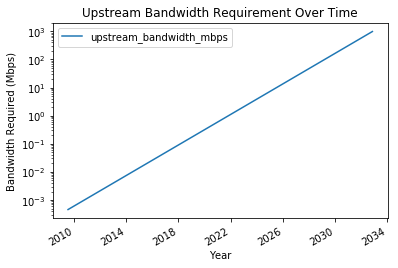

In [380]:
# bandwidth required to upload every block received 3x
df = future_sizes
upload_ratio = 3.0
bits_per_byte = 8.0
df['upstream_bandwidth_mbps'] = \
    (df['blocksize_trend_mb'] * bits_per_byte / seconds_per_block) * upload_ratio
ax = df.loc[100:].plot(x='timestamp', y='upstream_bandwidth_mbps', logy=True)
ax.set(title="Upstream Bandwidth Requirement Over Time",
       xlabel="Year", ylabel="Bandwidth Required (Mbps)")

As can be seen, there is a time around 2033 (after Bitcoin has eclipsed global digital
transactions by 5x) where it is possible upstream bandwidth required to keep a ratio
of 3.0 just barely exceeds what a symmetric 1Gbps connection can handle.

If by that time 2Gbps connections are not more prevalent (they started showing up in Japan
in 2013), some node operators running out of their homes may be forced to upload less
than a 3.0 up/down ratio.